# Basic Well Log Interpretation


The data used is available at this location: http://certmapper.cr.usgs.gov/data/PubArchives/OF00-200/WELLS/WALAKPA1/LAS/WA1LAS.HTM. <br>
The Walakpa1 Well is part of the USGS Open File Report 00-200 public dataset.

## 1. Read the data


Import data from text file into a pandas Dataframe called: "data".<br>
Null data (-999.00000) will be replace by numpy.nan and M__DEPTH changed with DEPT (much common abrevation in las files)</p>

In [102]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
import tsne

Visualize data:

In [103]:
data1=pd.read_table('data/SB20.LAS.txt', delim_whitespace=True)
core1=pd.read_table('data/SB20PNP.TXT', delim_whitespace=True)
data1['WELL'] = 1
data1 = pd.merge(data1, core1, on='M__DEPTH', how='left')

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:963: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


In [104]:
data2=pd.read_table('data/WA1.LAS.txt', delim_whitespace=True)
core2=pd.read_table('data/WA1PNP.TXT', delim_whitespace=True)
data2['WELL'] = 2
data2 = pd.merge(data2, core2, on='M__DEPTH', how='left')

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:963: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


In [105]:
data3=pd.read_table('data/WA2.LAS.txt', delim_whitespace=True)
core3=pd.read_table('data/WA2PNP.TXT', delim_whitespace=True)
data3.rename(columns={'LLD':'ILD', 'LLS':'ILM'}, inplace=True)
data3['WELL'] = 3
data3 = pd.merge(data3, core3, on='M__DEPTH', how='left')

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:963: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


In [106]:
cols = [x for x in data2.columns if x in data3.columns]
print(cols)

['M__DEPTH', 'SP', 'GR', 'CALI', 'BitSize', 'ILM', 'ILD', 'RHOB', 'NPHI', 'DT', 'MudWgt', 'WELL', 'PERM', 'POR', 'DEN', 'SO', 'SW']


In [107]:
data = data2[cols].append(data3[cols], ignore_index=True)
data = data.replace(-999.00000,np.nan)
data=data.rename(columns=({'M__DEPTH':'DEPT'}))

In [108]:
data_sample = data.copy()
for col in ['DEPT', 'SP', 'GR', 'CALI', 'ILM', 'ILD', 'RHOB', 'NPHI', 'DT']:
    data_sample = data_sample.loc[~data_sample[col].isnull()]

In [109]:
tsne_cols = ['SP', 'GR', 'CALI', 'ILM', 'ILD', 'RHOB', 'NPHI', 'DT']

scaler = StandardScaler()
X = scaler.fit_transform(data_sample[tsne_cols].values)

In [110]:
X_tsne = tsne.bh_sne(X, perplexity=50)

In [111]:
X_tsne = pd.DataFrame(X_tsne)
X_tsne.columns = ['tsne1', 'tsne2']
X_tsne['WELL'] = data_sample['WELL']
X_tsne['DEPT'] = data_sample['DEPT']

<Figure size 432x288 with 0 Axes>

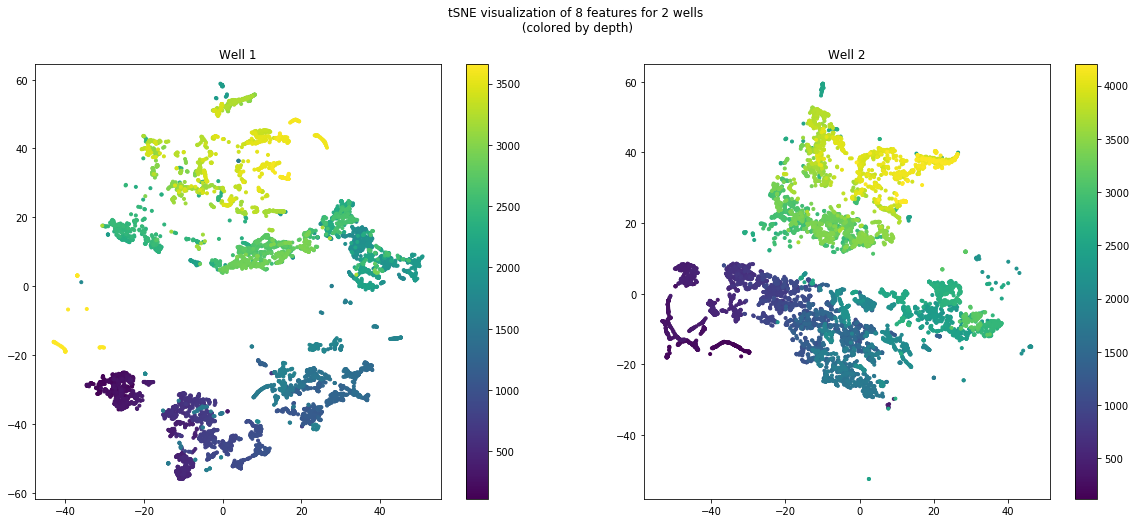

In [112]:
plt.clf()
fig = plt.figure(figsize=(20,8))
plt.suptitle('tSNE visualization of 8 features for 2 wells\n (colored by depth)')
ax1 = plt.subplot(1, 2, 1)
sc1 = ax1.scatter(X_tsne.loc[X_tsne['WELL']==2, 'tsne1'].values, 
                  X_tsne.loc[X_tsne['WELL']==2, 'tsne2'], 
                  c=X_tsne.loc[X_tsne['WELL']==2,'DEPT'].values,
                  marker='.')
ax1.set_title('Well 1')
fig.colorbar(sc1)
ax2 = plt.subplot(1, 2, 2)
sc2 = ax2.scatter(X_tsne.loc[X_tsne['WELL']==3, 'tsne1'].values, 
                  X_tsne.loc[X_tsne['WELL']==3, 'tsne2'], 
                  c=X_tsne.loc[X_tsne['WELL']==3,'DEPT'].values,
                  marker='.')
ax2.set_title('Well 2')
fig.colorbar(sc2)
plt.savefig('tsne_vizualization.png', bbox_inches='tight')

### Add formation tops & depth from the Geologic Report to lists
 http://certmapper.cr.usgs.gov/data/PubArchives/OF00-200/WELLS/WALAKPA1/PDF/WA1PDF.HTM

In [113]:
tops = ('Torok','Pebble SH','Walakpa SS', 'J-Klingak','Barrow SS','Klingak SH','T-Sag River SS', 'Shublik','Basement')
tops_depths=(100,1701,2071,2087,2990, 3102,3224,3258,3633)

### 2.  Display the logs

A triple-combo display will be created in matplotlib in order to visualize the curves.
The template will be incorporated into the <i>triple combo_plot</i> function dependent on the selection of top and bottom depths of the graph.

The triple combo display will consist in:
- First track: GR, SP, CALI
- Second track: Resistivities
- Third Track: Density, Sonic and Neutronic

In the next code lines, we will set the template.

In [118]:
# Create the figure and subplots
def triple_combo_plot(data, top_depth,bottom_depth):
    
    logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,10), sharey=True)
    fig.suptitle("Well Composite", fontsize=22)
    fig.subplots_adjust(top=0.75,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(tops_depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        
#1st track: GR, CALI, SP track
    
    ax01=ax[0].twiny()
    ax01.set_xlim(-100,10)
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel("SP [mV]")
    ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
    ax01.set_xlabel('SP[mV]',color='blue')    
    ax01.tick_params(axis='x', colors='blue')
    ax01.grid(True)
    
    ax02=ax[0].twiny()
    ax02.set_xlim(6,36)
    ax02.plot(logs.CALI, logs.DEPT, '--', label='CALN[in]', color='black') 
    ax02.spines['top'].set_position(('outward',40))
    ax02.set_xlabel('CALI[in]',color='black')    
    ax02.tick_params(axis='x', colors='black')
    
    ax03=ax[0].twiny()
    ax03.set_xlim(0,150)
    ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green') 
    ax03.spines['top'].set_position(('outward',80))
    ax03.set_xlabel('GR[api]',color='green')    
    ax03.tick_params(axis='x', colors='green')
    
#2nd track: Resistivities

    ax11=ax[1].twiny()
    ax11.set_xlim(1.0,100)
    ax11.set_xscale('log')
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('ILD[m.ohm]', color='red')
    ax11.plot(logs.ILD, logs.DEPT, label='ILD[m.ohm]', color='red')
    ax11.tick_params(axis='x', colors='red')    
    
    ax12=ax[1].twiny()
    ax12.set_xlim(1.0,100)
    ax12.set_xscale('log')
    ax12.plot(logs.ILM, logs.DEPT, label='ILM[m.ohm]', color='purple') 
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('ILM[m.ohm]', color='purple')    
    ax12.tick_params(axis='x', colors='purple')
    
#3rd track: DT, RHOB, NPHI track
    
    ax21=ax[2].twiny()
    ax21.grid(True)
    ax21.set_xlim(140,40)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel('DT[us/ft]')
    ax21.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
    ax21.set_xlabel('DT[us/ft]', color='blue')    
    ax21.tick_params(axis='x', colors='blue')
    
    ax22=ax[2].twiny()
    ax22.set_xlim(-15,45)
    ax22.invert_xaxis()
    ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green') 
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('NPHI[%]', color='green')    
    ax22.tick_params(axis='x', colors='green')
    
    ax23=ax[2].twiny()
    ax23.set_xlim(1.95,2.95)
    ax23.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red') 
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('RHOB[g/cc]',color='red')
    ax23.tick_params(axis='x', colors='red')
    
    plt.savefig ('triple_combo_plot.png', dpi=200, format='png')

 - Display the logs for the whole well

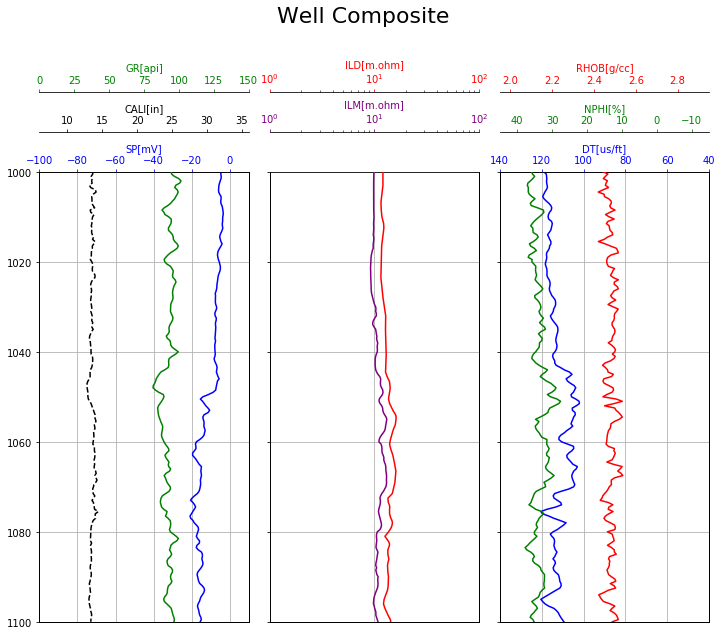

In [119]:
#%matplotlib nbagg

#triple_combo_plot(data.DEPT.min(),data.DEPT.max())
triple_combo_plot(data.loc[data['WELL']==2], 1000, 1100)

A ZONE for analysis will be selected from the entire log. Let's display again the logs within the choosen interval with triple_combo_plot function.

### Select zone of analysis: top and depth
by setting the "top_depth" and "bottom_depth" variables

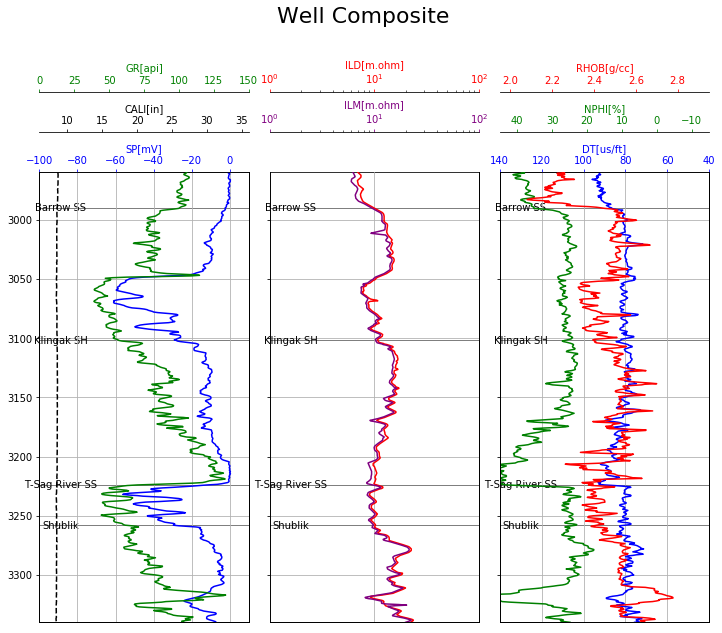

In [121]:
top_depth= 2960
bottom_depth=3340

triple_combo_plot(data.loc[data['WELL']==2], top_depth,bottom_depth)

### 3. Calculate Volume of Clay


The first step of a basic well log analysis will begin with the volume of clay calculation.

There are several methods used to perform that, clasified as:
- Single methods: Gamma Ray Log, Spontaneous Potential, VCLRT
or by
- Dual Methods: Neutron-Density, it is based on a N-D Crossplot, where a clean line and a clay point will be defined, as you will see in the graphs below.


In [122]:
#VCLGR
def vclgr(gr_log, gr_clean, gr_clay, correction=None):

    igr=(gr_log-gr_clean)/(gr_clay-gr_clean)       #Linear Gamma Ray
    vclgr_larionov_young=0.083*(2**(3.7*igr)-1)   #Larionov (1969) - Tertiary rocks
    vclgr_larionov_old=0.33*(2**(2*igr)-1)        #Larionov (1969) - Older rocks
    vclgr_clavier=1.7-(3.38-(igr+0.7)**2)**0.5    #Clavier (1971)
    vclgr_steiber=0.5*igr/(1.5-igr)               #Steiber (1969) - Tertiary rocks

    if correction == "young":
        vclgr=vclgr_larionov_young
    elif correction == "older":
        vclgr=vclgr_larionov_old
    elif correction=="clavier":
        vclgr=vclgr_clavier
    elif correction=="steiber":
        vclgr=vclgr_steiber
    else:
        vclgr=igr
    return vclgr

#VCLSP
def vclsp(sp_log, sp_clean, sp_clay):
    vclsp=(sp_log-sp_clean)/(sp_clay-sp_clean)
    return vclsp

#VCLRT
def vclrt(rt_log, rt_clean,rt_clay):
    vrt=(rt_clay/rt_log)*(rt_clean-rt_log)/(rt_clean-rt_clay)
    if (rt_log > 2* rt_clay):
        vclrt = 0.5 * (2 * vrt)** (0.67*(vrt+1)) 
    else:
        vclrt = vrt
    return vclrt

#VCLND
def vclnd(neut_log,den_log,neut_clean1,den_clean1,neut_clean2,den_clean2,neut_clay,den_clay):
    term1 = (den_clean2-den_clean1)*(neut_log-neut_clean1)-(den_log-den_clean1)*(neut_clean2-neut_clean1)
    term2 =(den_clean2-den_clean1)*(neut_clay-neut_clean1)-(den_clay-den_clean1)*(neut_clean2-neut_clean1)
    vclnd=term1/term2
    return vclnd


 - Declaration of the variables for clean and clay zones for VCL calculations: (We can come back here any time to modify the parameters for VCL eq!!!)

In [123]:
# Input parameters 
logs=data.loc[((data.DEPT >= top_depth) & (data.DEPT <= bottom_depth) & (data.WELL == 2))].copy()

gr_clean, gr_clay = 40, 135
sp_clean, sp_clay = -60,2

neut_clean1, den_clean1 = 15, 2.6
neut_clean2, den_clean2 = 40, 2
neut_clay, den_clay =47.5, 2.8

#calculate the VCL functions, by looping with pandas series values through VCL functions defined above
# without looping - the function will throw an error
vclgr_temp,vclnd_temp, vclrt_temp, vclsp_temp =[],[],[],[]

for (i,j,k,l,m) in zip(logs.GR,logs.NPHI,logs.RHOB,logs.ILD,logs.SP):
    vclgr_temp.append(vclgr(i, gr_clean, gr_clay))
    vclnd_temp.append(vclnd(j,k,neut_clean1,den_clean1,neut_clean2,den_clean2,neut_clay,den_clay))
    vclsp_temp.append(vclsp(m, sp_clean, sp_clay))
    
logs['VCLGR']=vclgr_temp
logs['VCLND']=vclnd_temp
logs['VCLSP']=vclsp_temp
del vclgr_temp, vclnd_temp, vclsp_temp         #remove the arrays to free mem



We will create several displays (GR,SP vs DEPTH track, histograms, N-D crossplot, VCL track) in order to see and choose the right parameters for our clay/clean formations as well as to compare the results of all VCL methods calculated above.
        

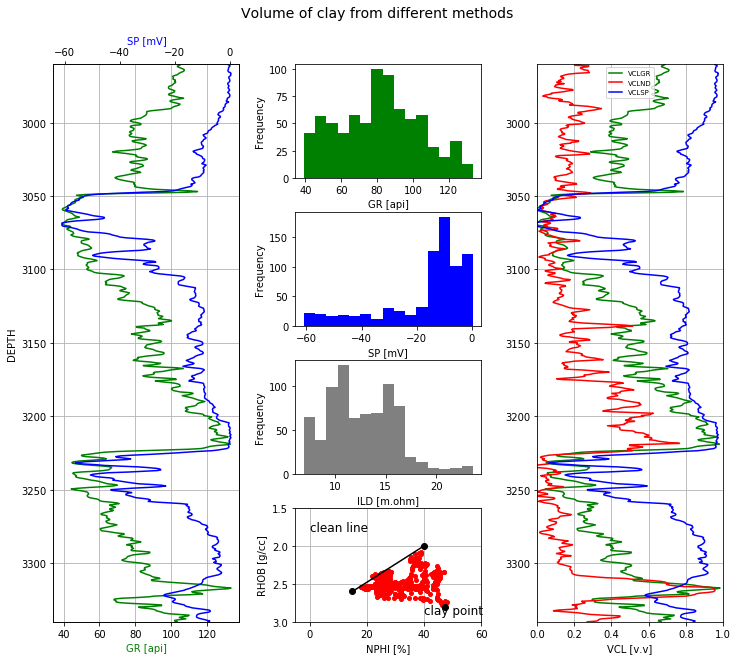

In [138]:
from matplotlib import gridspec

#logs=data.iloc[[top_depth],[bottom_depth]]
#logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
#print (logs.GR,logs.LLD)
#Setting GRAPH ELEMENTS

fig = plt.figure(figsize=(12,10))
fig.suptitle('Volume of clay from different methods',fontsize=14)
fig.subplots_adjust(top=0.90,wspace=0.3, hspace =0.3)

gs = gridspec.GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[3,1])
ax6 = fig.add_subplot(gs[:,2],sharey = ax1)

# Graph for GR,SP

ax1.invert_yaxis()
ax1.grid(True)
ax1.set_ylabel('DEPTH')
ax1.plot(logs.GR, logs.DEPT, color='green')
ax1.set_xlabel('GR [api]', color='green')

ax11=ax1.twiny()
ax11.plot(logs.SP, logs.DEPT, color='blue')
ax11.set_xlabel("SP [mV]",color='blue')


#The graph of GR histogram
ax2.hist(logs.GR.dropna(),bins=15,color='green')
ax2.set_xlabel('GR [api]')
ax2.set_ylabel('Frequency')

ax3.hist(logs.SP.dropna(),bins=15, color='blue')
ax3.set_xlabel('SP [mV]')
ax3.set_ylabel('Frequency')

ax4.hist(logs.ILD.dropna(),bins=15, color='gray')
ax4.set_xlabel('ILD [m.ohm]')
ax4.set_ylabel('Frequency')


# N-D XPlot for Volume of Clay


ax5.plot(logs.NPHI, logs.RHOB,'ro',markersize=4)
ax5.set_xlabel('NPHI [%]')
ax5.set_xlim(-5,60)
ax5.set_ylim(3,1.5)
ax5.set_ylabel('RHOB [g/cc]')
ax5.grid(True)
ax5.text(0, 1.8, 'clean line', fontsize=12)
ax5.text(40, 2.9, 'clay point', fontsize=12)
ax5.plot([neut_clean1,neut_clean2],[den_clean1,den_clean2], marker='o', color='black')
ax5.plot(neut_clay,den_clay,'ro',color='black')


#plt.title("Volume of Clay")

ax6.plot(logs.VCLGR, logs.DEPT, label ='VCLGR',color="green")
ax6.plot(logs.VCLND, logs.DEPT,label ='VCLND',color="red")
ax6.plot(logs.VCLSP, logs.DEPT,label ='VCLSP',color="blue")
ax6.legend(loc='best',fontsize='x-small')
ax6.set_xlim(0,1)
ax6.set_ylim(top_depth,bottom_depth)
ax6.invert_yaxis()
ax6.grid(True)
ax6.set_xlabel('VCL [v.v]')

plt.savefig ('vcl_plot.png', dpi=200, format='png')

Use the histrograms to re-evaluate:
 - GR min, max (clean, clay)
 - SP min, max (clean, clay)
 - RT min, max (clean, clay)
From ND Xplot extract the clean line and clay point.

All VCLGR (you can apply any correction here), VCLSP, VCLRT and VCLND curves are plotted in the same track for comparison. It is obvious that the VCLGR and VCLND match very well, comparing with the rest.

To simplify the intepretation we will accept the VCLGR as the VCL. Another approch is to consider vcl as the minimum value obtained through several methods (VCL = min (VCLGR,VCLSP,VCLND)).

In [127]:
logs['VCL']=logs['VCLGR']

### 4. The Porosity:
 
Three logs are available for porosity estimation: sonic, density and neutronic. Porosity can be evaluated by single or dual combinations of any three types mentioned: neutron-density, neutron-sonic and sonic-density.
Basic porosity formulas are:
 - Sonic: Willie, Raymer-Hunt-Gardner;
 - Density;
 - Neutronic;<br>
<p>The NEUTRON-DENSITY combinations give the best result in any type of lithology.</p>

In [128]:
#Willie-TimeAverage
def phis_shale(dt_sh, dt_ma, dt_fl):
    phis_shale = (dt_sh-dt_ma)/(dt_fl-dt_ma)
    return phis_shale
def phis_w(dt_log, dt_ma, dt_fl, cp):
    phis_w=(1/cp)*(dt_log-dt_ma)/(dt_fl-dt_ma)
    return phis_w
def phis_w_sh_corr(dt_log, dt_ma, dt_fl, cp, dt_sh, vcl):
    phis_w=(1/cp)*(dt_log-dt_ma)/(dt_fl-dt_ma)
    phis_w_sh = (dt_sh-dt_ma)/(dt_fl-dt_ma)
    phis_w_sh_corr = phis_w - vcl * phis_w_sh
    return phis_w_sh_corr

#Raymer-Hunt-Gardner (the alpha(5/8) ranges from 0.625-0.70, 0.67-most, 0.60-gas reservoirs)
def phis_rhg(dt_log, dt_ma, alpha):
    phis_rhg=(alpha)*(dt_log-dt_ma)/(dt_log)
    return phis_rhg
def phis_rhg_sh_corr(dt_log, dt_ma, dt_sh, vcl):
    phis_rhg=(5/8)*(dt_log-dt_ma)/(dt_log)
    phis_rhg_sh = (dt_sh-dt_ma)/(dt_fl-dt_ma)
    phis_rhg_sh_corr = phis_rhg - vcl * phis_rhg_sh
    return phis_rhg_sh_corr

#Density
def phid(den_log, den_ma, den_fl, den_sh, vcl):
    phid = (den_log - den_ma) / (den_fl - den_ma)
    return phid
def phid_shale(den_sh, den_ma, den_fl):
    phid_shale = (den_sh - den_ma) / (den_fl - den_ma)
    return phid_shale
def phid_sh_corr(den, den_ma, den_fl, den_sh, vcl):
    phid = (den - den_ma) / (den_fl - den_ma)
    phid_sh = (den_sh - den_ma) / (den_fl - den_ma)
    phid_sh_corr = phid - vcl * phid_sh
    return phid_sh_corr

# NEUTRON:
def phin_sh_corr(neut, neut_sh, vcl):
    phin_sh_corr = (neut-vcl*neut_sh)/100
    return phin_sh_corr

#Neutron-Density
def phixnd(phinshc, phidshc):
    phixnd= (phinshc + phidshc) / 2
    return phixnd
def phixnd_gas_corr(phin, phid, phin_sh, phid_sh):
    phixnd_gas_corr= ((phin**2+phin**2)/2)**(0.5)    #for gas intervals (nphi<dphi = crossover)
    return phixnd_gas_corr

 - Select the variables for shale/clean zones and calculate porosities:

In [129]:
#Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5,188.0,90.0,1,5/8
den_ma, den_fl, den_sh = 2.65, 1.1, 2.4

phis_sh=phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh=phis_shale(den_sh, den_ma, den_fl)
phin_sh=45

#calculate the VCL functions, by looping with pandas series values through VCL functions defined above

logs['PHISw']=phis_w(logs.DT, dt_ma, dt_fl, cp)
logs['PHISwshc']=phis_w_sh_corr(logs.DT, dt_ma, dt_fl, cp, dt_sh, logs.VCL).clip(0,1)

logs['PHISrhg']=phis_rhg(logs.DT, dt_ma, alpha)
logs['PHISrhgshc']=phis_rhg_sh_corr(logs.DT, dt_ma, dt_sh, logs.VCL).clip(0,1)

logs['PHID']=phid(logs.RHOB, den_ma, den_fl, den_sh, logs.VCL)
logs['PHIDshc']=phid_sh_corr(logs.RHOB, den_ma, den_fl, den_sh, logs.VCL).clip(0,1)

logs['PHIN']=logs.NPHI/100
logs['PHINshc']=phin_sh_corr(logs.NPHI, phin_sh, logs.VCL).clip(0,1)

logs['PHIxND']=phixnd(logs.PHINshc,logs.PHIDshc).clip(0,1)

A PHIxND porosity is a good estimation of effective porosity.
Calculated porosities above are similar with core porosities (see http://certmapper.cr.usgs.gov/data/PubArchives/OF00-200/WELLS/WALAKPA1/LAS/WA1LOG.JPG)

In [130]:
logs['PHIE']=logs['PHIxND']

### Machine learning for porosity

Processing fold 1
Error of predictions: 0.00019502352295039683
Processing fold 2
Error of predictions: 0.00038757358422867867
Processing fold 3
Error of predictions: 0.0005767002515439719


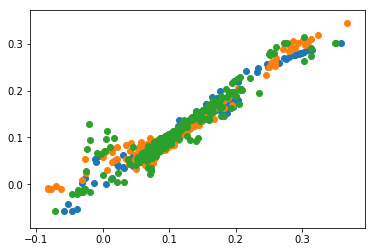

In [131]:
from sklearn import svm
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

feats = ['RHOB','NPHI','DT']
X = logs[feats].values
y = logs['PHID'].values

scaler = StandardScaler()
scaler.fit(X)
Xscaled = scaler.transform(X)

if False:
    clf = svm.SVR(C=1.0, kernel='linear', coef0=0.0, degree=3, epsilon=0.1, tol=0.001)

if True:
    clf = neural_network.MLPRegressor(hidden_layer_sizes=(10,10,),
                                      batch_size='auto',
                                      activation='relu',
                                      solver='adam',
                                      beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                                      learning_rate='adaptive',
                                      max_iter=10000,
                                      learning_rate_init=0.001,
                                      momentum=0.9,
                                      nesterovs_momentum=True,
                                      alpha=1)

kf = KFold(n_splits=3, shuffle=True)
index_count = 0
plt.clf()
for train_index, test_index in kf.split(Xscaled):
    index_count += 1
    print("Processing fold {}".format(index_count))
    X_train, X_test = Xscaled[train_index], Xscaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    plt.scatter(y_test, y_pred)
    print("Error of predictions: {}".format(mean_squared_error(y_pred, y_test)))

### 5. Water Saturation

Before calculating the water saturation will need a value for the Rw (Resistivity of water)

##### Resistivity of water 
It can be determined from:
 - water catalogs
 - DST test water analysis
 - Rw from SP (needs information about Rmud and ... )
 - Rwa Method (Rw from a 100% water zone)

Assume that we have no ideea about the Rwater, then best practice is a PICKETT graph.
This plot is logarithmic plot after Archie's equation:

##### Archie Water Saturation Eq.

Sw^n = (a * Rw) / (Rt * PHI ^ m)

Equation can be re-write in a logarithm way and plotted in a log graph RT vs PHI:

log(PHI) = - (1 / m) * log(R_t) - n * log(Sw) + log( a * Rw)

We need to define first the variables: a, m, n. You can start with this pair(a=1,m=2,n=2) as it works well in most of lithologies. If your matrix is shaly-mixed, the you can decrease the m to 1.8.

In [132]:
a=1 #turtuosity factor
m=1.8 #cementation factor
n=2 #saturation exponent

Then choose the water resistivity: rwa.
We'll plot Resistivity vs Porosity in Pickett chart.
Data can be selected just in the reservoir formations (excluding the shaly intervals) by playing with the vcl_limit (volume of clay) variable.

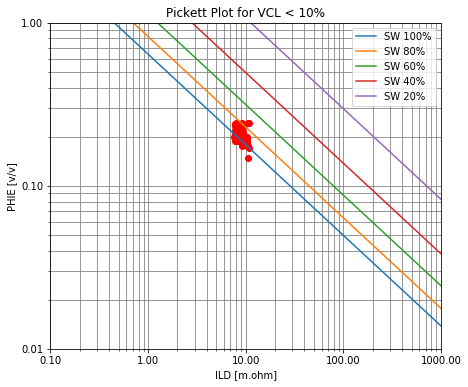

In [133]:
rwa=0.45       #water resistivity
vcl_limit=0.1 #volume of clay upper limit for selction of data for graph

import matplotlib.ticker as ticker

pickett_figure=plt.figure(figsize=(7,6))
plt.title('Pickett Plot'+ ' for VCL < '+str(int(vcl_limit*100))+'%')
plt.loglog(logs.ILD[logs.VCL<vcl_limit],logs.PHIE[logs.VCL<vcl_limit],'ro', label='',color='red')
plt.xlim(0.1,1000)
plt.ylim(0.01,1)
plt.ylabel('PHIE [v/v]')
plt.xlabel('ILD [m.ohm]')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

#calculate the saturation lines
sw_plot=(1.0,0.8,0.6,0.4,0.2)
phie_plot=(0.01,1)
rt_plot=np.zeros((len(sw_plot),len(phie_plot)))
                
for i in range (0,len(sw_plot)):
    for j in range (0,len(phie_plot)):
        rt_result=((a*rwa)/(sw_plot[i]**n)/(phie_plot[j]**m))
        rt_plot[i,j]=rt_result      
for i in range(0,len(sw_plot)):
    plt.plot(rt_plot[i],phie_plot, label='SW '+str(int(sw_plot[i]*100))+'%')
    plt.legend (loc='best')
plt.grid(True, which='both',ls='-',color='gray')

#plt.savefig('pickett.png', dpi=200, format='png')

From the Picket plot results that we are dealing with two different zone intervals, that need to be divided and interpreted separately. <br>
For now, we will choose a resonable Rwa and calculate the Sw curve with Archie. Add the equation in a function named: sw_archie,

In [134]:
def sw_archie(Rw, Rt, Poro, a, m, n):
        F = a / (Poro**m)
        Sw_archie = (F * Rw/Rt)**(1/n)
        return Sw_archie

and call it in order to have the result of saturation Swa. Clip the results between (0,1).

In [135]:
Rw =rwa
logs['SWa']=(sw_archie(Rw,logs.ILD,logs.PHIE,a,m,n)).clip(0,1)

Calculate the BVW (bulk volume of water):

In [136]:
logs['BVW']=logs['SWa']*logs['PHIE']
logs['matrix']=1-logs.VCL-logs.PHIE

### 6. Display the "Interpretation Plot"

Create a plot template and add the results of volume of clay, saturation and porosity.

In [ ]:
import matplotlib.pyplot as plt
# Create the figure and subplots

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(14,9), sharey=True)
fig.suptitle("Interpretation Plot", fontsize=22)
fig.subplots_adjust(top=0.75,wspace=0.1)

#General setting for all axis
for axes in ax:
    axes.set_ylim (top_depth,bottom_depth)
    axes.invert_yaxis()
    axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False)
    for i in tops_depths:
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
for (i,j) in zip(tops_depths,tops):
    if ((i>=top_depth) and (i<=bottom_depth)):
        ax[0].text(0.2, i ,j, horizontalalignment='center',verticalalignment='center')                
    
#1st track: GR, SP, CALI track
ax01=ax[0].twiny()
ax01.set_xlim(-100,10)
ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
ax01.set_xlabel('SP[mV]',color='blue')    
ax01.tick_params(axis='x', colors='blue')
    
ax02=ax[0].twiny()
ax02.set_xlim(6,36)
ax01.grid(True)
ax02.plot(logs.CALI, logs.DEPT, '--', label='CALI[in]', color='black') 
ax02.spines['top'].set_position(('outward',40))
ax02.set_xlabel('CALI[in]',color='black')    
ax02.tick_params(axis='x', colors='black')
    
ax03=ax[0].twiny()
ax03.set_xlim(0,150)
ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green') 
ax03.spines['top'].set_position(('outward',80))
ax03.set_xlabel('GR[api]',color='green')    
ax03.tick_params(axis='x', colors='green')

#2nd track: Resistivities
ax11=ax[1].twiny()
ax11.set_xlim(1.0,100)
ax11.set_xscale('log')
ax11.grid(True)
ax11.spines['top'].set_position(('outward',80))
ax11.set_xlabel('ILD[m.ohm]', color='red')
ax11.plot(logs.ILD, logs.DEPT, label='ILD[m.ohm]', color='red')
ax11.tick_params(axis='x', colors='red')    

ax12=ax[1].twiny()
ax12.set_xlim(1.0,100)
ax12.set_xscale('log')
ax12.plot(logs.ILM, logs.DEPT, label='ILM[m.ohm]', color='purple') 
ax12.spines['top'].set_position(('outward',40))
ax12.set_xlabel('ILM[m.ohm]', color='purple')    
ax12.tick_params(axis='x', colors='purple')
    
#3rd track: DT, RHOB, NPHI track
ax21=ax[2].twiny()
ax21.grid(True)
ax21.set_xlim(140,40)
ax21.spines['top'].set_position(('outward',0))
ax21.set_xlabel('DT[us/ft]')
ax21.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
ax21.set_xlabel('DT[us/ft]', color='blue')    
ax21.tick_params(axis='x', colors='blue')
    
ax22=ax[2].twiny()
ax22.set_xlim(-15,45)
ax22.invert_xaxis()
ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green') 
ax22.spines['top'].set_position(('outward',40))
ax22.set_xlabel('NPHI[%]', color='green')    
ax22.tick_params(axis='x', colors='green')
    
ax23=ax[2].twiny()
ax23.set_xlim(1.95,2.95)
ax23.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red') 
ax23.spines['top'].set_position(('outward',80))
ax23.set_xlabel('RHOB[g/cc]',color='red')
ax23.tick_params(axis='x', colors='red')
 

#4th track: SW
ax31=ax[3].twiny()
ax31.grid(True)
ax31.set_xlim(1,0)
ax31.plot(logs.SWa, logs.DEPT, label='SWa', color='black',linewidth=0.5)
#ax31.plot(logs.SWs, logs.DEPT, label='SWs', color='green',linewidth=0.5)
ax31.spines['top'].set_position(('outward',0))
ax31.set_xlabel('SWa', color='black')    
ax31.tick_params(axis='x', colors='black')
    
#5th track: PHIE, BVW
ax41=ax[4].twiny()
ax41.grid(True)
ax41.set_xlim(1,0)
ax41.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black', linewidth=0.5)
ax41.fill_betweenx(logs.DEPT,0,logs.BVW,color='lightblue')
ax41.spines['top'].set_position(('outward',0))
ax41.set_xlabel('PHIE', color='black')    
ax41.tick_params(axis='x', colors='black')

ax42=ax[4].twiny()
ax42.set_xlim(1,0)
ax42.plot(logs.BVW, logs.DEPT, label='BVW', color='black')
ax42.fill_betweenx(logs.DEPT,logs.PHIE, logs.BVW,color='red')
ax42.spines['top'].set_position(('outward',40))
ax42.set_xlabel('BVW', color='black')    
ax42.tick_params(axis='x', colors='black')

#6th track: PHIE, MATRIX, VCL

ax50=ax[5].twiny()
ax50.set_xlim(1,0)
ax50.spines['top'].set_position(('outward',0))
ax50.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black',linewidth=0.5)
ax50.set_xlabel('PHIE]', color='blue')    
ax50.tick_params(axis='x', colors='blue')

ax51=ax[5].twiny()
ax51.set_xlim(0,1)
ax51.spines['top'].set_position(('outward',40))
ax51.plot(logs.VCL, logs.DEPT, label='VCL', color='green',linewidth=0.5)
ax51.set_xlabel('VCL', color='green')    
ax51.tick_params(axis='x', colors='green')

ax52=ax[5].twiny()
ax52.set_xlim(1,0)
ax52.spines['top'].set_position(('outward',0))
ax52.fill_betweenx(logs.DEPT,0,logs.PHIE,color='lightgray',label='porosity')
ax52.fill_betweenx(logs.DEPT,logs.PHIE,1-logs.VCL,color='orange',label='matrix')
ax52.fill_betweenx(logs.DEPT,1-logs.VCL,1,color='lightgreen',label= 'Vclay')
ax52.legend(loc='lower left')

#plt.savefig ('interpretation_plot.png', dpi=200, format='png')

## 7. Summary

A small example of an average properties over an interval, can be done as follows: 

ZONE:  3050 m - 3220 m
Mean values:


SWa     0.985143
BVW     0.074786
PHIE    0.078083
VCL     0.438778
dtype: float64

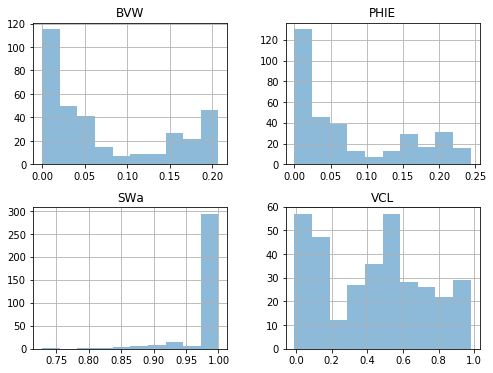

In [40]:
top_summary = 3050
depth_summary = 3220

logs.loc[top_summary:depth_summary,{'PHIE','SWa','BVW','VCL'}].hist(figsize=(8, 6),alpha=0.5)
print ('ZONE: ', top_summary, 'm -', depth_summary, 'm')
print ('Mean values:')
logs.loc[top_summary:depth_summary,{'PHIE','SWa','BVW','VCL'}].mean()

Then we can incorporate our calculated logs into the main pandas dataframe:

In [41]:
curves_to_export={'PHIE','SWa','BVW','VCL'}
for x in curves_to_export:
    data[x] =logs[x]

You have the option to export the dataframe to a csv file:

In [42]:
logs.to_csv('W1 Well Logs.csv', encoding='utf-8')

or you can export it to Excel:

In [45]:
from pandas import ExcelWriter

writer=ExcelWriter('W1 Well Logs.xlsx')
logs.to_excel(writer, sheet_name='Logs', index=False)
writer.save()